In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from utils import set_seed
from plot_utils import plot_eval_results

set_seed()


In [2]:

from mnist_utils import plot_samples
from config import cfg
from vanilla_model import fit as fit_vanilla
from metrics import calc_metrics
from converters import Converter
from config import cfg
from eval import run_tflite_model
from c_utils import write_model_h
from utils import save_test_data
import plot_utils as pu

In [3]:
from nyuv2_torch_ds_adapter import get_tf_nyuv2_ds
import argparse
args = argparse.Namespace()
args.truncate_testset = False
# args.target_size = (64, 64)
args.crop_size = (640, 480)
# args.target_size = (64, 64)
args.target_size = cfg.img_size
args.out_fold_ratio = 1
args.is_maxim = False
# args.batch_size = cfg.batch_size*4
args.batch_size=1
ds_train, ds_val, ds_test = get_tf_nyuv2_ds(cfg.base_kitti_dataset_dir, args)
# x=next(iter(ds_train.shuffle(100).batch(2).take(1)))
# pu.plot_sample_nyuv2(x)
train_size=cfg.take_first_n
ds_train = ds_train.batch(cfg.batch_size).take(train_size)
val_size=cfg.take_first_n
ds_val = ds_val.batch(cfg.batch_size).take(val_size)
test_size=cfg.take_first_n
ds_test = ds_test.batch(cfg.batch_size).take(test_size)

x_val= next(iter(ds_val))
x_train= next(iter(ds_train))
x_test= next(iter(ds_test))

Dataset: NYU Depth V2
# of train images: 50688
Dataset: NYU Depth V2
# of test images: 654
Train size:  40551
Val size:  10137
Test size:  654


-0.04789474 0.014210528
-0.04789474 0.014210528
0.13526316 2.5577962


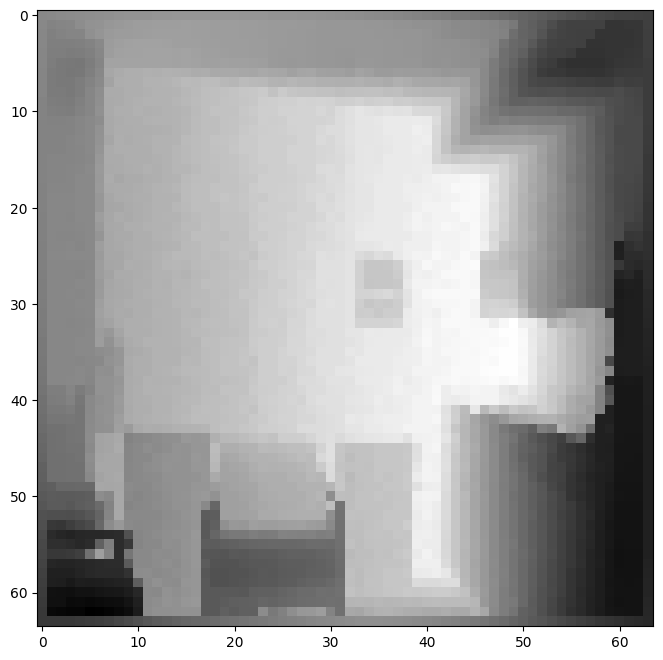

In [4]:
print(x_train[1].numpy().min(), x_train[1].numpy().max())
print(x_val[1].numpy().min(), x_val[1].numpy().max())
print(x_test[1].numpy().min(), x_test[1].numpy().max())
plt.imshow(x_test[1][0].numpy().squeeze())

In [5]:
from loss import calculate_loss
from model import get_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

keras.backend.clear_session()
# loss = tf.keras.losses.MeanSquaredError()
metrics = tf.keras.metrics.Mean(name="loss")
mae_loss = tf.keras.losses.MeanAbsoluteError()


# Define a custom metric
def custom_metric(y_true, y_pred, sample_weight=None):
    return mae_loss(y_true, y_pred, sample_weight=sample_weight)
    metric_value = calculate_loss(y_true, y_pred)
    metrics.update_state(metric_value, sample_weight=sample_weight)
    # return {"loss2": metrics.result()}
    # return metric_value

model = get_model(
    cfg.img_size,
    cfg.num_classes
)
# model = keras.models.load_model(
#     "/media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/depth_model_fp32.h5",
#     custom_objects={"custom_metric": custom_metric}
# )

In [9]:
x_train[1][0].shape

TensorShape([1, 64, 64, 1])

1/1 [==============================] - 0s 14ms/step
MAE: 0.08, RMSE: 0.01, loss: 0.76


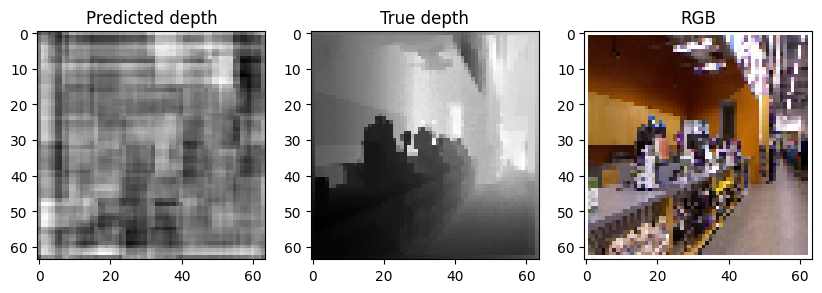

In [12]:
out = model.predict(x_train[0][0])
plot_eval_results(out[0], x_train[1][0][0], x_train[0][0][0])

In [22]:
from eval import eval_model


metrics = eval_model(model, ds_test, tflite_path="/tmp/models/depth_full_quant.tflite", model_name="test",
                     metrics_file_path=f"{cfg.save_model_dir}/metrics.json")

# eval_model(model, ds_test, tflite_path="/tmp/models/pruned_qat_model.tflite", model_name="test")

test model metrics:
mse: 54330.258
mae: 232.218
eval_loss: 1.359
eval_metric: 1.049
Saved metrics to /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/metrics.json


In [23]:
x_train[0].numpy().min(), x_train[0].numpy().max(), x_train[1].numpy().min(), x_train[1].numpy().max()

(0.0, 1.0, -0.2409375, -0.17124999)

In [12]:
model.evaluate(ds_test, batch_size=1, verbose=1)

7/7 [==============================] - 2s 295ms/step - loss: 1.3431 - custom_metric: 1.1518


[1.3430613279342651, 1.1517744064331055]

In [13]:
out.min(), out.max(), x_train[1][0].numpy().min(), x_train[1][0].numpy().max()

(-0.88279116, 0.17683801, -0.2409375, -0.17124999)

In [14]:
calculate_loss(out[0], x_train[1][0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5899138>